# Import Libraries & Dataset

In [73]:
# Import libraries | Standard
import pandas as pd
import numpy as np
import os
import datetime
import warnings
from time import time

# Import libraries | Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Import libraries | Sk-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics.scorer import make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

import xgboost as xgb
from lightgbm import LGBMRegressor

# Pretty display for notebooks
%matplotlib inline

In [6]:
pd.set_option('display.max_columns', None)  

pd.set_option('display.max_rows', None)

In [69]:
warnings.filterwarnings('ignore')

In [8]:
def train_predict(learner, sample_size, train_X, train_y, test_X, test_y): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set       
       - train_X: features training set
       - train_y: income training set
       - test_X: features testing set
       - test_y: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data
    start = time() # Get start time
    learner = learner.fit(train_X[:sample_size], train_y[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['time_train'] = end - start
        
    # Get the predictions on the test set(X_test),
    start = time() # Get start time
    predictions = learner.predict(test_X)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['time_pred'] = end - start
            
    # Compute Mean Squared Error on Test Set
    results['MSE'] = mean_squared_error(test_y, predictions)

    # Compute Mean Accuracy Error on Test Set
    results['MAE'] = mean_absolute_error(test_y, predictions)
    
    # Compute Weighted Mean Absolute Error on Test Set
    results['WMAE'] = weighted_mean_absolute_error(test_y, predictions, compute_weights(test_X['IsHoliday']))
                   
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [9]:
def evaluate(results):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
    """
  
    # Create figure
    fig, ax = plt.subplots(1, 3, figsize = (11,7))

    # Constants
    bar_width = 0.2
    colors = ['#A00000','#00A0A0','#00A000','#A00000','#00A0A0']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        #for j, metric in enumerate(['time_train', 'time_pred', 'MSE', 'MAE', 'WMAE']):
        for j, metric in enumerate(['time_train', 'time_pred', 'WMAE']):
            for i in np.arange(6):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    #ax[0, 1].set_ylabel("Accuracy Score")
    #ax[0, 2].set_ylabel("F-score")
    ax[0, 1].set_ylabel("Time (in seconds)")
    #ax[1, 0].set_ylabel("MSE")
    #ax[1, 1].set_ylabel("MAE")    
    ax[0, 2].set_ylabel("WMAE")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    #ax[0, 1].set_title("Accuracy Score on Training Subset")
    #ax[0, 2].set_title("F-score on Training Subset")
    ax[0, 1].set_title("Model Predicting")
    #ax[1, 0].set_title("MSE on Testing Set")
    #ax[1, 1].set_title("MAE on Testing Set")
    ax[0, 2].set_title("WMAE on Testing Set")
 
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [10]:
def feature_plot(importances, train_X, train_y, topk=5):
    
    # Display the most important features
    indices = np.argsort(importances)[::-1]
    columns = train_X.columns.values[indices[:topk]]
    values = importances[indices][:topk]

    # Creat the plot
    fig = plt.figure(figsize = (18,5))
    plt.title("Normalized Weights for First " + str(topk) + " Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(topk), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(topk) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(topk), columns)
    plt.xlim((-0.5, 9.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper left')
    plt.tight_layout()
    plt.show()  

In [11]:
def reduce_mem_usage(df, verbose=True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))    
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [12]:
def compute_weights(holidays):
    return holidays.apply(lambda x: 1 if x==0 else 5)

In [13]:
def weighted_mean_absolute_error(pred_y, test_y, weights):
    return 1/sum(weights) * sum(weights * abs(test_y - pred_y))

In [18]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

cnt = 0
env = 'Outside Kaggle'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        cnt += 1
        print(os.path.join(dirname, filename))
        
if cnt > 0:
    env = 'Kaggle Kernel'

In [19]:
print('Environment:', env)

Environment: Outside Kaggle


In [12]:
# Read input files
if env == 'Kaggle':
    features = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv")
    stores = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv")
    train = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv")
    test = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv")
else:    
    features = pd.read_csv("data/features.csv")
    stores = pd.read_csv("data/stores.csv")
    train = pd.read_csv("data/train.csv")
    test = pd.read_csv("data/test.csv")

In [13]:
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Memory usage of dataframe is 13.27 MB
Memory usage after optimization is: 6.03 MB
Decreased by 54.5%
Memory usage of dataframe is 2.74 MB
Memory usage after optimization is: 1.21 MB
Decreased by 56.0%


# Data Exploration

### 1. Stores Data

In [11]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [12]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.1+ KB


In [13]:
stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [14]:
#missing data
total = stores.isnull().sum().sort_values(ascending=False)
percent = (stores.isnull().sum()/stores.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Size,0,0.0
Type,0,0.0
Store,0,0.0


### 2. Features Data

In [15]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [16]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             7605 non-null float64
Unemployment    7605 non-null float64
IsHoliday       8190 non-null bool
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 711.9+ KB


In [17]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [18]:
#missing data
total = features.isnull().sum().sort_values(ascending=False)
percent = (features.isnull().sum()/features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
MarkDown2,5269,0.643346
MarkDown4,4726,0.577045
MarkDown3,4577,0.558852
MarkDown1,4158,0.507692
MarkDown5,4140,0.505495
Unemployment,585,0.071429
CPI,585,0.071429
IsHoliday,0,0.000000
Fuel_Price,0,0.000000
Temperature,0,0.000000


In [19]:
# Distribution of NaNs for all columns
features_missing = features.isna().sum()/len(features) * 100

<BarContainer object of 12 artists>

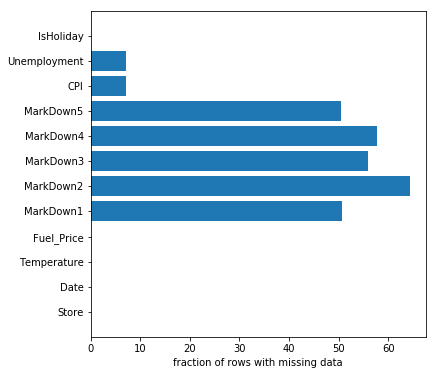

In [20]:
plt.figure(figsize=(6,6))
plt.yticks(np.arange(len(features_missing)),features_missing.index,rotation='horizontal')
plt.xlabel('fraction of rows with missing data')
plt.barh(np.arange(len(features_missing)), features_missing)

In [21]:
features['Date'].str.slice(start=0, stop=4).value_counts()

2011    2340
2012    2340
2010    2160
2013    1350
Name: Date, dtype: int64

In [22]:
holidays = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08', #Super Bowl
           '2010-09-10', '2011-09-09', '2012-09-07', '2013-02-06',  #Labor Day
           '2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29',  #Thanksgiving
           '2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']  #Christmas

In [23]:
# Validate Holidays
features['IsHoliday'][features['Date'].isin(holidays)].value_counts()

True    585
Name: IsHoliday, dtype: int64

In [24]:
features['Date'][features['IsHoliday'].isin([1])][~features['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

In [ ]:
print(features.head().append(features.tail()),"\n")
print("Structure of Feature: ",features.shape,"\n")
print("Summary Statistic:\n",features.describe(),"\n")
print("Count of missing values:\n",features.isnull().sum().sort_values(ascending=False),"\n")

### 3. Train Data

In [25]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.500000,False
1,1,1,2010-02-12,46039.488281,True
2,1,1,2010-02-19,41595.550781,False
3,1,1,2010-02-26,19403.539062,False
4,1,1,2010-03-05,21827.900391,False


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int8
Dept            421570 non-null int8
Date            421570 non-null object
Weekly_Sales    421570 non-null float32
IsHoliday       421570 non-null bool
dtypes: bool(1), float32(1), int8(2), object(1)
memory usage: 6.0+ MB


In [27]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15978.299805
std,12.785297,30.492054,22707.693359
min,1.000000,1.000000,-4988.939941
25%,11.000000,18.000000,2079.649902
50%,22.000000,37.000000,7612.029785
75%,33.000000,74.000000,20205.852051
max,45.000000,99.000000,693099.375000


In [28]:
train['Date'].str.slice(start=0, stop=4).value_counts()

2011    153453
2010    140679
2012    127438
Name: Date, dtype: int64

In [29]:
# Validate Holidays
train['IsHoliday'][train['Date'].isin(holidays)].value_counts()

True    29661
Name: IsHoliday, dtype: int64

In [30]:
train['Date'][train['IsHoliday'].isin([1])][~train['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


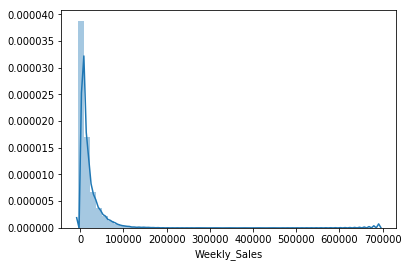

In [31]:
#histogram
sns.distplot(train['Weekly_Sales'])

In [32]:
train['Store'][train['Weekly_Sales'] < 0].sum()

30658

### 4. Test Data

In [33]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
Store        115064 non-null int8
Dept         115064 non-null int8
Date         115064 non-null object
IsHoliday    115064 non-null bool
dtypes: bool(1), int8(2), object(1)
memory usage: 1.2+ MB


In [35]:
test.describe()

,Store,Dept
count,115064.000000,115064.000000
mean,22.238207,44.339524
std,12.809930,30.656410
min,1.000000,1.000000
25%,11.000000,18.000000
50%,22.000000,37.000000
75%,33.000000,74.000000
max,45.000000,99.000000


In [36]:
test['Date'].str.slice(start=0, stop=4).value_counts()

2013    88275
2012    26789
Name: Date, dtype: int64

In [37]:
# Validate Holidays
test['IsHoliday'][test['Date'].isin(holidays)].value_counts()

True    8928
Name: IsHoliday, dtype: int64

In [38]:
train['Date'][train['IsHoliday'].isin([1])][~train['Date'].isin(holidays)].value_counts()

Series([], Name: Date, dtype: int64)

# Data Pre-Processing

## 1. Fill NaN Values

### Features dataset has NaN values for multiple columns:

##### Columns: CPI and Unemployment

In [39]:
features['Date'].str.slice(start=0, stop=7)[features['CPI'].isna()].value_counts()

2013-05    225
2013-07    180
2013-06    180
Name: Date, dtype: int64

In [40]:
features['Date'].str.slice(start=0, stop=7)[features['Unemployment'].isna()].value_counts()

2013-05    225
2013-07    180
2013-06    180
Name: Date, dtype: int64

In [41]:
features[['CPI','Unemployment']].groupby([features['Store'], features['Date'].str.slice(start=0, stop=7)]).mean().head(84)

CPI  Unemployment
Store Date                             
1     2010-02  211.236828         8.106
      2010-03  211.241116         8.106
      2010-04  210.552135         7.808
      2010-05  210.547812         7.808
      2010-06  211.356237         7.808
      2010-07  211.207476         7.787
      2010-08  211.578688         7.787
      2010-09  211.536531         7.787
      2010-10  211.800525         7.838
      2010-11  211.899611         7.838
      2010-12  211.457702         7.838
      2011-01  211.721611         7.742
      2011-02  213.071770         7.742
      2011-03  214.224260         7.742
      2011-04  215.258255         7.682
      2011-05  215.749441         7.682
      2011-06  215.101584         7.682
      2011-07  215.345630         7.962
      2011-08  215.638236         7.962
      2011-09  216.157134         7.962
      2011-10  217.398324         7.866
      2011-11  218.130899         7.866
      2011-12  219.149949         7.866
      2012-01  219.917832         7.348
      2012-02  220.374964         7.348
      2012-03  221.153294         7.348
      2012-04  221.531958         7.143
      2012-05  221.721270         7.143
      2012-06  221.781152         7.143
      2012-07  221.920490         6.908
...                   ...           ...
2     2011-02  212.727665         8.028
      2011-03  213.877488         8.028
      2011-04  214.908582         7.931
      2011-05  215.398826         7.931
      2011-06  214.754360         7.931
      2011-07  214.998246         7.852
      2011-08  215.291750         7.852
      2011-09  215.810080         7.852
      2011-10  217.047711         7.441
      2011-11  217.777737         7.441
      2011-12  218.792544         7.441
      2012-01  219.558147         7.057
      2012-02  220.014484         7.057
      2012-03  220.791516         7.057
      2012-04  221.170021         6.891
      2012-05  221.358968         6.891
      2012-06  221.419302         6.891
      2012-07  221.557961         6.565
      2012-08  221.721490         6.565
      2012-09  222.331393         6.565
      2012-10  222.992375         6.170
      2012-11  223.159882         6.170
      2012-12  223.427985         6.170
      2013-01  223.821473         6.237
      2013-02  223.925989         6.237
      2013-03  224.439928         6.237
      2013-04  224.781713         6.112
      2013-05         NaN           NaN
      2013-06         NaN           NaN
      2013-07         NaN           NaN

[84 rows x 2 columns]

In [42]:
%%time
# For each Store, propogate values of CPI & Unemployment to the rows with NaN values
for i in range(len(features)):

    if features.iloc[i]['Date'] == '2013-04-26':
        CPI_new = features.iloc[i]['CPI']
        Unemployment_new = features.iloc[i]['Unemployment']
    
    if np.isnan(features.iloc[i]['CPI']):
        features.iat[i, 9] = CPI_new
        features.iat[i, 10] = Unemployment_new

CPU times: user 2.54 s, sys: 0 ns, total: 2.54 s
Wall time: 2.54 s


##### Columns: MarkDown1, MarkDown2, MarkDown3, MarkDown4 & MarkDown5

In [43]:
features.groupby(features['Date'].str.slice(start=0, stop=7))['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'].count()

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5
Date,,,,,
2010-02,0,0,0,0,0
2010-03,0,0,0,0,0
2010-04,0,0,0,0,0
2010-05,0,0,0,0,0
2010-06,0,0,0,0,0
2010-07,0,0,0,0,0
2010-08,0,0,0,0,0
2010-09,0,0,0,0,0
2010-10,0,0,0,0,0


In [44]:
%%time
# For each date, retrive the corresponding week number
features['Week'] = 0

for i in range(len(features)):
    features.iat[i, 12] = datetime.date(int(features.iloc[i]['Date'][0:4]), 
                                        int(features.iloc[i]['Date'][5:7]), 
                                        int(features.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 3.98 s, sys: 2.04 ms, total: 3.99 s
Wall time: 3.99 s


In [45]:
features['Year'] = features['Date'].str.slice(start=0, stop=4)

In [46]:
features.to_csv('features_new.csv', index=False)

In [47]:
#missing data for 2012 & 2013
total = features[features['Year'].isin(['2012','2013'])].isnull().sum().sort_values(ascending=False)
percent = (features[features['Year'].isin(['2012','2013'])].isnull().sum()/
           features[features['Year'].isin(['2012','2013'])].isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(4)

,Total,Percent
MarkDown2,1062,0.287805
MarkDown4,528,0.143089
MarkDown3,419,0.113550
MarkDown1,12,0.003252


In [48]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 14 columns):
Store           8190 non-null int64
Date            8190 non-null object
Temperature     8190 non-null float64
Fuel_Price      8190 non-null float64
MarkDown1       4032 non-null float64
MarkDown2       2921 non-null float64
MarkDown3       3613 non-null float64
MarkDown4       3464 non-null float64
MarkDown5       4050 non-null float64
CPI             8190 non-null float64
Unemployment    8190 non-null float64
IsHoliday       8190 non-null bool
Week            8190 non-null int64
Year            8190 non-null object
dtypes: bool(1), float64(9), int64(2), object(2)
memory usage: 839.9+ KB


In [49]:
%%time
# For 2010 & 2011 records, for each store, copy over MarkDown values from 2012

# Iterate through stores
for i in range(1, len(features['Store'].unique())):
    
    # For 2010, iterate through weeks 5 thru 52
    for j in range(5, 52):
        idx = features.loc[(features.Year == '2010') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]
        
    # For 2011, iterate through weeks 1 thru 44
    for j in range(1, 44):
        idx = features.loc[(features.Year == '2011') & (features.Store == i) & (features.Week == j),['Date']].index[0]
        
        features.iat[idx, 4] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown1']].values[0]
        features.iat[idx, 5] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown2']].values[0]
        features.iat[idx, 6] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown3']].values[0]
        features.iat[idx, 7] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown4']].values[0]
        features.iat[idx, 8] = features.loc[(features.Year == '2012') & (features.Store == i) & (features.Week == j),['MarkDown5']].values[0]        

CPU times: user 1min 5s, sys: 149 ms, total: 1min 5s
Wall time: 1min 5s


In [51]:
features.drop(columns=['Year'], axis=1, inplace=True)

In [50]:
# Now fill all the missing MarkDown values with 0
features.fillna(0, inplace=True)

## 2. Merge Datasets

In [54]:
train = pd.merge(train, stores, how='left', on=['Store'])
train = pd.merge(train, features, how='left', on=['Store','Date'])

In [55]:
test = pd.merge(test, stores, how='left', on=['Store'])
test = pd.merge(test, features, how='left', on=['Store','Date'])

In [58]:
train['Store'][train['IsHoliday_x'] != train['IsHoliday_y']].count()

0

In [59]:
test['Store'][test['IsHoliday_x'] != test['IsHoliday_y']].count()

0

In [60]:
train.drop(columns=['IsHoliday_y'], axis=1, inplace=True)
test.drop(columns=['IsHoliday_y'], axis=1, inplace=True)

In [61]:
train.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)
test.rename(columns={'IsHoliday_x': 'IsHoliday'}, inplace=True)

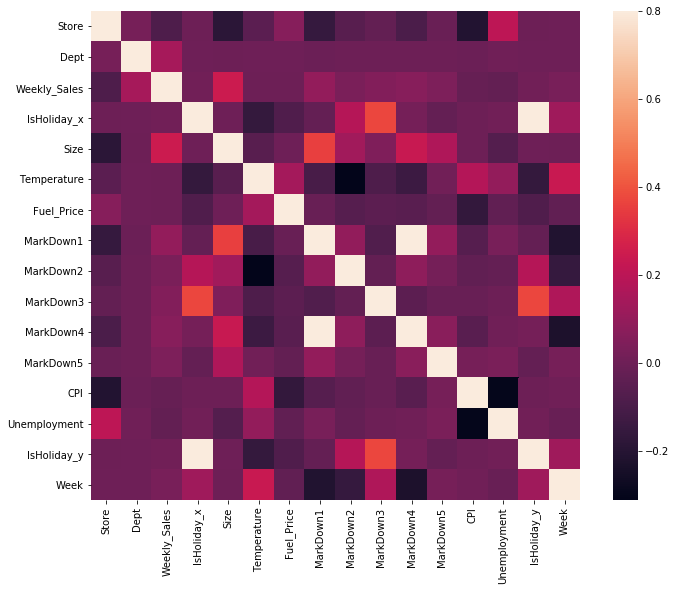

In [56]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

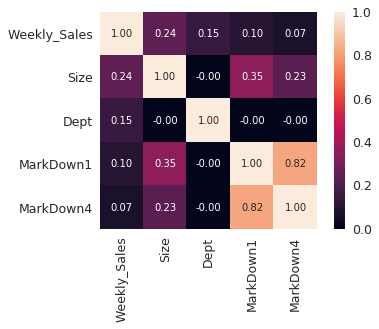

In [57]:
#saleprice correlation matrix
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Weekly_Sales')['Weekly_Sales'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## 3. Feature Engineering

#### Column: IsHoliday

In [65]:
train['IsHoliday'] = train['IsHoliday'].apply(lambda x: 1 if x==True else 0)
test['IsHoliday'] = test['IsHoliday'].apply(lambda x: 1 if x==True else 0)

#### Column: Type

In [62]:
train['Type'].value_counts()

A    215478
B    163495
C     42597
Name: Type, dtype: int64

In [63]:
test['Type'].value_counts()

A    58713
B    44500
C    11851
Name: Type, dtype: int64

In [64]:
train = pd.get_dummies(train, columns=['Type'])
test = pd.get_dummies(test, columns=['Type'])

#### Column: Week

In [66]:
train['Week'] = test['Week'] = 0

In [67]:
%%time
# For each date, retrive the corresponding week number
for i in range(len(train)):
    train.iat[i, 15] = datetime.date(int(train.iloc[i]['Date'][0:4]), 
                                     int(train.iloc[i]['Date'][5:7]), 
                                     int(train.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 3min 57s, sys: 12.3 ms, total: 3min 57s
Wall time: 3min 57s


In [68]:
%%time
# For each date, retrive the corresponding week number
for i in range(len(test)):
    test.iat[i, 14] = datetime.date(int(test.iloc[i]['Date'][0:4]), 
                                    int(test.iloc[i]['Date'][5:7]), 
                                    int(test.iloc[i]['Date'][8:10])).isocalendar()[1]

CPU times: user 1min 4s, sys: 7.96 ms, total: 1min 4s
Wall time: 1min 4s


#train['Year'] = train['Date'].str.slice(start=0, stop=4)
train['Month'] = train['Date'].str.slice(start=5, stop=7)

#test['Year'] = test['Date'].str.slice(start=0, stop=4)
test['Month'] = test['Date'].str.slice(start=5, stop=7)

In [14]:
submission = test[['Store', 'Dept', 'Date']].copy()

In [15]:
submission['Id'] = submission['Store'].map(str) + '_' + submission['Dept'].map(str) + '_' + submission['Date'].map(str)

In [16]:
submission.drop(['Store', 'Dept', 'Date'], axis=1, inplace=True)

train.drop(columns=['Date','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis=1, inplace=True)
test.drop(columns=['Date','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis=1, inplace=True)

In [72]:
train.drop(columns=['Date'], axis=1, inplace=True)
test.drop(columns=['Date'], axis=1, inplace=True)

In [73]:
train.drop(columns=['MarkDown1'], axis=1, inplace=True)
test.drop(columns=['MarkDown1'], axis=1, inplace=True)

### Scale Datasets

In [75]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
#numerical = ['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
numerical = ['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
             'MarkDown2','MarkDown3','MarkDown4','MarkDown5']

train_scaled = pd.DataFrame(data = train)
train_scaled[numerical] = scaler.fit_transform(train[numerical])

# Show an example of a record with scaling applied
display(train_scaled.head(n = 5))

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C
0,1,1,24924.500000,0,0.630267,0.434149,0.050100,0.036694,0.001268,0.480236,0.007346,0.840500,0.405118,5,1,0,0
1,1,1,46039.488281,1,0.630267,0.396967,0.038076,0.068645,0.000874,0.125556,0.008974,0.841941,0.405118,6,1,0,0
2,1,1,41595.550781,0,0.630267,0.410861,0.021042,0.108107,0.000260,0.124629,0.004459,0.842405,0.405118,7,1,0,0
3,1,1,19403.539062,0,0.630267,0.476419,0.044589,0.074646,0.000216,0.018080,0.010604,0.842707,0.405118,8,1,0,0
4,1,1,21827.900391,0,0.630267,0.475147,0.076653,0.017510,0.000267,0.376301,0.010505,0.843008,0.405118,9,1,0,0


In [76]:
test_scaled = pd.DataFrame(data = test)
test_scaled[numerical] = scaler.fit_transform(test[numerical])

# Show an example of a record with scaling applied
display(test_scaled.head(n = 5))

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C
0,1,1,0,0.630267,0.573142,0.410215,0.072893,0.001537,0.055703,0.003788,0.943588,0.443438,44,1,0,0
1,1,1,0,0.630267,0.627334,0.352753,0.047907,0.001467,0.071112,0.008215,0.943778,0.443438,45,1,0,0
2,1,1,0,0.630267,0.551172,0.303272,0.004610,0.001891,0.017341,0.008810,0.944101,0.443438,46,1,0,0
3,1,1,1,0.630267,0.581472,0.270551,0.000561,0.501726,0.003212,0.000633,0.944603,0.443438,47,1,0,0
4,1,1,0,0.630267,0.545862,0.267358,0.000503,0.026844,0.002304,0.009268,0.945105,0.443438,48,1,0,0


In [17]:
train = test = features = stores = None

In [78]:
train_scaled.to_csv('train_scaled.csv', index=False)
test_scaled.to_csv('test_scaled.csv', index=False)

AttributeError: 'NoneType' object has no attribute 'astype'

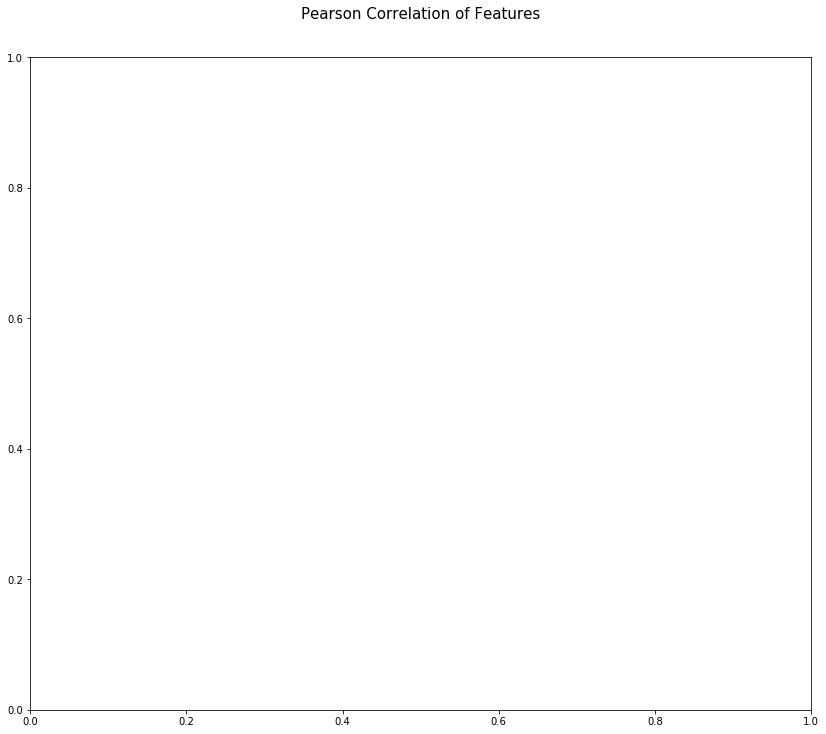

In [37]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_scaled.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [20]:
train_scaled = pd.read_csv("train_scaled.csv")
test_scaled = pd.read_csv("test_scaled.csv")

In [21]:
weekly_sales = train_scaled['Weekly_Sales']
train_scaled = train_scaled.drop('Weekly_Sales', axis = 1)

In [22]:
(weekly_sales < 0).value_counts()

False    420285
True       1285
Name: Weekly_Sales, dtype: int64

weekly_sales = weekly_sales.apply(lambda x: 0 if x < 0 else x)

train_scaled['MarkDown2'] = train_scaled['MarkDown2'].apply(lambda x: 0 if x < 0 else x)
train_scaled['MarkDown3'] = train_scaled['MarkDown3'].apply(lambda x: 0 if x < 0 else x)
train_scaled['MarkDown4'] = train_scaled['MarkDown4'].apply(lambda x: 0 if x < 0 else x)
train_scaled['MarkDown5'] = train_scaled['MarkDown5'].apply(lambda x: 0 if x < 0 else x)

test_scaled['MarkDown2'] = test_scaled['MarkDown2'].apply(lambda x: 0 if x < 0 else x)
test_scaled['MarkDown3'] = test_scaled['MarkDown3'].apply(lambda x: 0 if x < 0 else x)
test_scaled['MarkDown4'] = test_scaled['MarkDown4'].apply(lambda x: 0 if x < 0 else x)
test_scaled['MarkDown5'] = test_scaled['MarkDown5'].apply(lambda x: 0 if x < 0 else x)

### Split Training dataset into Train & Validation

In [23]:
train_X, val_X, train_y, val_y = train_test_split(train_scaled, weekly_sales, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(train_X.shape[0]))
print("Validation set has {} samples.".format(val_X.shape[0]))

Training set has 337256 samples.
Validation set has 84314 samples.


In [24]:
train_scaled = weekly_sales = None

In [25]:
train_X.shape,val_X.shape, test_scaled.shape

((337256, 16), (84314, 16), (115064, 16))

In [26]:
train_X=reduce_mem_usage(train_X)
val_X=reduce_mem_usage(val_X)
test_scaled=reduce_mem_usage(test_scaled)

Memory usage of dataframe is 43.74 MB
Memory usage after optimization is: 10.61 MB
Decreased by 75.7%
Memory usage of dataframe is 10.94 MB
Memory usage after optimization is: 2.65 MB
Decreased by 75.7%
Memory usage of dataframe is 14.05 MB
Memory usage after optimization is: 2.74 MB
Decreased by 80.5%


In [70]:
%%time
# Initialize the models
model_A = RandomForestRegressor(random_state=1)
model_B = GradientBoostingRegressor(random_state=1)
model_C = BaggingRegressor(random_state=1)
model_D = xgb.XGBRegressor()
model_E = LGBMRegressor()

samples_100 = len(train_y)              # 100% of training set
samples_10 = int(samples_100 * 10/100)  #  10% of training set
samples_1 = int(samples_100 * 1/100)    #   1% of training set

# Collect results on the learners
results = {}
for model in [model_A, model_B, model_C, model_D, model_E]:
    model_name = model.__class__.__name__
    results[model_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[model_name][i] = \
        train_predict(model, samples, train_X, train_y, val_X, val_y)

# Run metrics visualization for the three supervised learning models chosen
#vs.evaluate(results, accuracy, fscore)

RandomForestRegressor trained on 3372 samples.
RandomForestRegressor trained on 33725 samples.
RandomForestRegressor trained on 337256 samples.
GradientBoostingRegressor trained on 3372 samples.
GradientBoostingRegressor trained on 33725 samples.
GradientBoostingRegressor trained on 337256 samples.
BaggingRegressor trained on 3372 samples.
BaggingRegressor trained on 33725 samples.
BaggingRegressor trained on 337256 samples.
[13:26:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor trained on 3372 samples.
[13:26:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor trained on 33725 samples.
[13:26:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor trained on 337256 samples.
LGBMRegressor trained on 3372 samples.
LGBMRegressor trained on 33725 sam

In [71]:
results

{'RandomForestRegressor': {0: {'time_train': 0.3790264129638672,
   'time_pred': 0.18720054626464844,
   'MSE': 126233752.19331597,
   'MAE': 6168.1004303081345,
   'WMAE': 6440.35445360685},
  1: {'time_train': 2.7552714347839355,
   'time_pred': 0.2397630214691162,
   'MSE': 34277487.72524958,
   'MAE': 2640.291394311739,
   'WMAE': 2905.095440809051},
  2: {'time_train': 34.47066259384155,
   'time_pred': 0.5360424518585205,
   'MSE': 12966331.537491873,
   'MAE': 1490.8571734587374,
   'WMAE': 1651.5429860211443}},
 'GradientBoostingRegressor': {0: {'time_train': 0.24490952491760254,
   'time_pred': 0.12472772598266602,
   'MSE': 154489551.03064263,
   'MAE': 7425.760564625704,
   'WMAE': 7696.615790166407},
  1: {'time_train': 2.1294994354248047,
   'time_pred': 0.12491679191589355,
   'MSE': 127146647.75850277,
   'MAE': 6827.236189320766,
   'WMAE': 7010.239781046169},
  2: {'time_train': 44.226179361343384,
   'time_pred': 0.12682604789733887,
   'MSE': 127352918.57493791,
   '

IndexError: too many indices for array

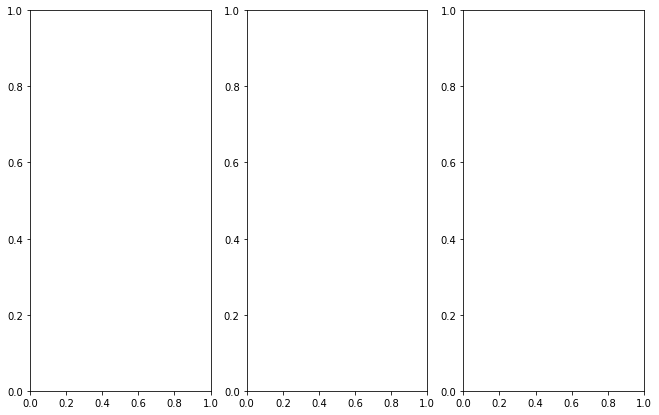

In [72]:
evaluate(results)

In [85]:
# This is our local data directory. We need to make sure that it exists.
data_dir = 'input'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

## Ensemble | Random Forest

In [24]:
%%time
model = RandomForestRegressor(random_state=42, n_estimators=100)

CPU times: user 37 µs, sys: 5 µs, total: 42 µs
Wall time: 44.8 µs


In [25]:
%%time
model.fit(train_X, train_y)

CPU times: user 5min 36s, sys: 1.22 s, total: 5min 37s
Wall time: 5min 38s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [26]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
wmae = weighted_mean_absolute_error(pred_y, val_y, compute_weights(val_X['IsHoliday']))
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
print("Weighted Mean Absolute Error: ", wmae)
pred_y = None

Mean Squared Error:  3378.8389828079094
Mean Absolute Error: 1405.6419241217354
Weighted Mean Absolute Error:  1574.4974530698164


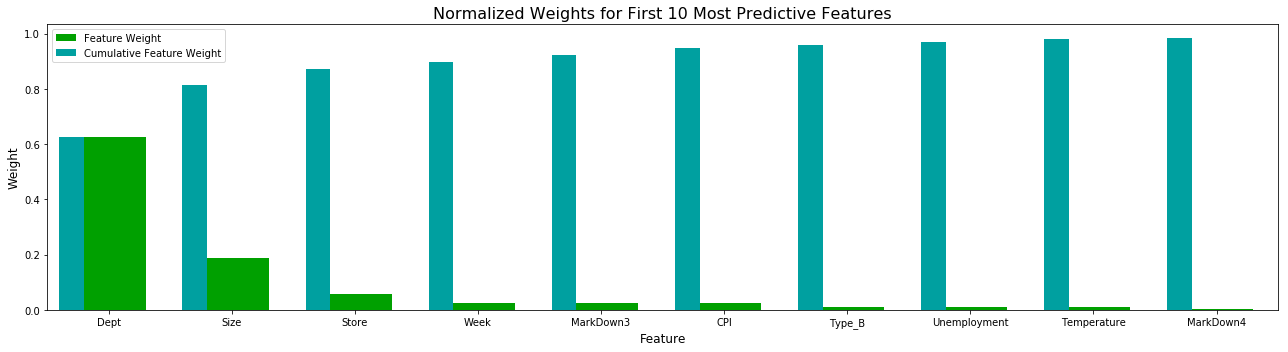

In [28]:
#Extract the feature importances
importances = model.feature_importances_

# Plot
feature_plot(importances, train_X, train_y, 10)

In [ ]:
topk = 17
indices = np.argsort(importances)[::-1]
columns = train_X.columns.values[indices[:topk]]
values = importances[indices][:topk]

for i in range(topk):
    print(columns[i] + '\t: ' + str(values[i]))

In [ ]:
pred_y_rf = model.predict(val_X)

In [29]:
pred_y_rf = model.predict(test_scaled)

In [15]:
param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
}

In [18]:
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
CV.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': ['auto'], 'max_depth': [4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
CV.best_params_

{'max_depth': 4, 'max_features': 'auto'}

## Boosting | LGBM

In [ ]:
# Default model
model = LGBMRegressor()

In [38]:
%%time
model.fit(train_X, train_y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [39]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
pred_y = None

Mean Squared Error:  6703.868115543201
Mean Absolute Error: 4094.6735975356155


In [39]:
model = LGBMRegressor()

In [45]:
param_grid = {
    'boosting_type': ['gbdt'], # for better accuracy -> try dart
    'objective': ['regression'],
    'random_state': [0],
    'learning_rate': [0.3],
    'n_estimators': [3000, 4000],
    'num_leaves': [60, 70, 80], # large num_leaves helps improve accuracy but might lead to over-fitting
    #'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    #'colsample_bytree': [0.5, 1],
    #'subsample': [0.5, 1],
    'reg_alpha': [0.05, 0.1],
    'reg_lambda': [1.5, 2],
    'min_child_samples': [5, 10]
}

In [ ]:
#CV_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid_lgbm, cv=3, verbose=1, scoring='neg_mean_absolute_error')
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)
CV.fit(train_X, train_y)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [49]:
print("Best parameter (CV score=%0.3f):" % CV.best_score_)
print(CV.best_params_)

Best parameter (CV score=0.979):
{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'min_child_samples': 5, 'n_estimators': 4000, 'num_leaves': 80, 'objective': 'regression', 'random_state': 0, 'reg_alpha': 0.1, 'reg_lambda': 2}


Best parameter (CV score=0.956):
{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 30, 'objective': 'regression', 'random_state': 0}

Best parameter (CV score=0.976):
{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'min_child_samples': 10, 'n_estimators': 1000, 'num_leaves': 40, 'objective': 'regression', 'random_state': 0, 'reg_alpha': 0.5}

Best parameter (CV score=0.978):
{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'min_child_samples': 10, 'n_estimators': 2000, 'num_leaves': 50, 'objective': 'regression', 'random_state': 0, 'reg_alpha': 0.1, 'reg_lambda': 1}
     
Best parameter (CV score=0.979):
{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'min_child_samples': 10, 'n_estimators': 3000, 'num_leaves': 60, 'objective': 'regression', 'random_state': 0, 'reg_alpha': 0.1, 'reg_lambda': 1.5}

Best parameter (CV score=0.979):
{'boosting_type': 'gbdt', 'learning_rate': 0.3, 'min_child_samples': 5, 'n_estimators': 4000, 'num_leaves': 80, 'objective': 'regression', 'random_state': 0, 'reg_alpha': 0.1, 'reg_lambda': 2}

In [59]:
# Using best params from GridSearch
model.set_params(**CV.best_params_)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.3, max_depth=-1,
       min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=4000, n_jobs=-1, num_leaves=80, objective='regression',
       random_state=0, reg_alpha=0.1, reg_lambda=2, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=1)

In [51]:
%%time
model.fit(train_X, train_y)

CPU times: user 2min 7s, sys: 1.38 s, total: 2min 8s
Wall time: 1min 6s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.3, max_depth=-1,
       min_child_samples=5, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=4000, n_jobs=-1, num_leaves=80, objective='regression',
       random_state=0, reg_alpha=0.1, reg_lambda=2, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
       verbose=1)

In [52]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
wmae = weighted_mean_absolute_error(pred_y, val_y, compute_weights(val_X['IsHoliday']))
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
print("Weighted Mean Absolute Error: ", wmae)
pred_y = None

Mean Squared Error:  2648.0593859167043
Mean Absolute Error: 1349.9283965517059
Weighted Mean Absolute Error:  1439.572109619736


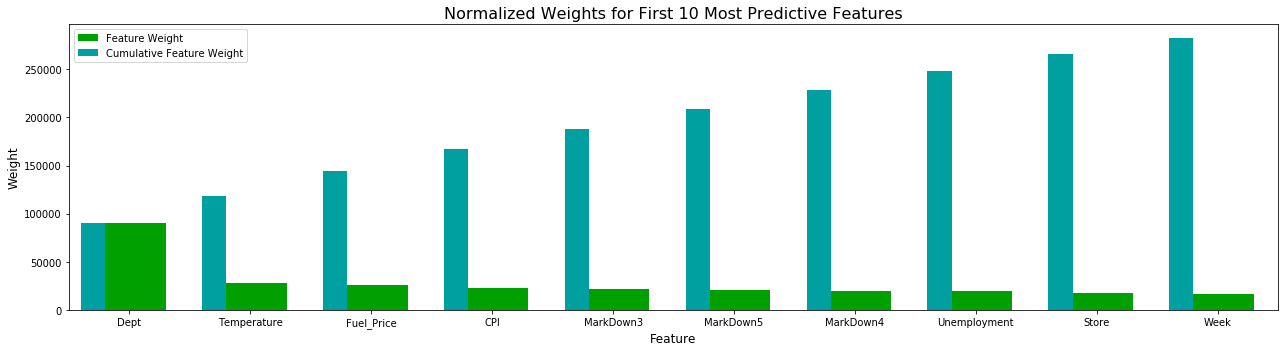

In [53]:
#Extract the feature importances
importances = model.feature_importances_

# Plot
feature_plot(importances, train_X, train_y, 10)

In [ ]:
pred_y_lgbm = model.predict(val_X)

In [35]:
pred_y_lgbm = model.predict(test_scaled)

In [41]:
pred_y = model.predict(test_scaled)

## XGB

In [74]:
# Default model
model = xgb.XGBRegressor()

In [75]:
%%time
# Add silent=True to avoid printing out updates with each cycle
model.fit(train_X, train_y, verbose=False)

[18:17:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 23.1 s, sys: 107 ms, total: 23.2 s
Wall time: 23.6 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [76]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
wmae = weighted_mean_absolute_error(pred_y, val_y, compute_weights(val_X['IsHoliday']))
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
print("Weighted Mean Absolute Error: ", wmae)
pred_y = None

Mean Squared Error:  11309.706774161677
Mean Absolute Error: 6858.918969562958
Weighted Mean Absolute Error:  7016.0501128682035


In [85]:
param_grid = {'model__n_estimators': [1000],
              'model__max_depth': [1],
              #'model__learning_rate': [0.05, 0.1, 0.5],
              'model__learning_rate': [0.05],
              'model__booster':['gbtree'],
              #'model__min_child_weight':[0.5, 1, 2],
              'model__min_child_weight':[0.5],
              'model__objective':['reg:squarederror'],
              'model__gamma':[0.5],
              'model__random_state':[0],
              #'model__max_delta_step':[0, 0.01, 0.1, 1, 10, 100]
              'model__subsample':[1],
              'model__colsample_bytree':[1],
              'model__colsample_bylevel':[1],
              'model__colsample_bynode':[1],
              #'model__reg_lambda':[0.000001, 0.005, 0.01],
              'model__reg_lambda':[0.000001],
              'model__reg_alpha':[0.00001, 0.0001, 0.001, 0.005]
              #'model__reg_alpha':[0.001, 0.05, 1]
             }

In [ ]:
CV = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)
CV.fit(train_X, train_y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[04:47:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
print("Best parameter (CV score=%0.3f):" % CV.best_score_)
print(CV.best_params_)

Best parameter (CV score=0.749):
{'model__booster': 'gbtree', 'model__gamma': 0.01, 'model__learning_rate': 0.01, 'model__max_depth': 1, 'model__min_child_weight': 0, 'model__n_estimators': 100, 'model__objective': 'reg:squarederror'}
       
Best parameter (CV score=0.749):
{'model__booster': 'gbtree', 'model__colsample_bylevel': 1, 'model__colsample_bynode': 1, 'model__colsample_bytree': 1, 'model__gamma': 0.5, 'model__learning_rate': 0.1, 'model__max_depth': 1, 'model__min_child_weight': 0, 'model__n_estimators': 1000, 'model__objective': 'reg:squarederror', 'model__random_state': 0, 'model__reg_alpha': 0.001, 'model__subsample': 1}

Best parameter (CV score=0.749):
{'model__booster': 'gbtree', 'model__colsample_bylevel': 1, 'model__colsample_bynode': 1, 'model__colsample_bytree': 1, 'model__gamma': 0.5, 'model__learning_rate': 0.1, 'model__max_depth': 1, 'model__min_child_weight': 0, 'model__n_estimators': 3000, 'model__objective': 'reg:squarederror', 'model__random_state': 0, 'model__reg_alpha': 0.001, 'model__subsample': 1}

Best parameter (CV score=0.749):
{'model__booster': 'gbtree', 'model__colsample_bylevel': 1, 'model__colsample_bynode': 1, 'model__colsample_bytree': 1, 'model__gamma': 0.5, 'model__learning_rate': 0.05, 'model__max_depth': 1, 'model__min_child_weight': 0.5, 'model__n_estimators': 1000, 'model__objective': 'reg:squarederror', 'model__random_state': 0, 'model__reg_alpha': 0.001, 'model__reg_lambda': 1e-06, 'model__subsample': 1}

In [82]:
# Using best params from GridSearch
model.set_params(**CV.best_params_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None,
       model__booster='gbtree', model__colsample_bylevel=1,
       model__colsample_bynode=1, model__colsample_bytree=1,
       model__gamma=0.5, model__learning_rate=0.05, model__max_depth=1,
       model__min_child_weight=0.5, model__n_estimators=1000,
       model__objective='reg:squarederror', model__random_state=0,
       model__reg_alpha=0.001, model__reg_lambda=1e-06, model__subsample=1,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [83]:
%%time
model.fit(train_X, train_y, verbose=False)

[04:42:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 22.4 s, sys: 104 ms, total: 22.5 s
Wall time: 22.6 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None,
       model__booster='gbtree', model__colsample_bylevel=1,
       model__colsample_bynode=1, model__colsample_bytree=1,
       model__gamma=0.5, model__learning_rate=0.05, model__max_depth=1,
       model__min_child_weight=0.5, model__n_estimators=1000,
       model__objective='reg:squarederror', model__random_state=0,
       model__reg_alpha=0.001, model__reg_lambda=1e-06, model__subsample=1,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [84]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
wmae = weighted_mean_absolute_error(pred_y, val_y, compute_weights(val_X['IsHoliday']))
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
print("Weighted Mean Absolute Error: ", wmae)
pred_y = None

Mean Squared Error:  11309.706774161677
Mean Absolute Error: 6858.918969562958
Weighted Mean Absolute Error:  7016.0501128682035


In [29]:
model = xgb.XGBRegressor(max_depth=3,learning_rate=0.1,n_estimators=1000,reg_alpha=0.001,reg_lambda=0.000001,n_jobs=-1,min_child_weight=3)
model.fit(train_X,train_y)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:58:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=3, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.001, reg_lambda=1e-06, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [30]:
# make predictions
pred_y = model.predict(val_X)
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
wmae = weighted_mean_absolute_error(pred_y, val_y, compute_weights(val_X['IsHoliday']))
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
print("Weighted Mean Absolute Error: ", wmae)
pred_y = None

Mean Squared Error:  7695.17370601781
Mean Absolute Error: 4487.445923625764
Weighted Mean Absolute Error:  4599.157449484859


## Model Stacking

In [36]:
# Blend the results of the two regressors and save the prediction to a CSV file.

pred_y = (pred_y_rf + pred_y_lgbm) / 2
#pred_y = np.exp(pred_y)

In [69]:
# make predictions
mse = mean_squared_error(val_y, pred_y)
rmse = np.sqrt(mse)
wmae = weighted_mean_absolute_error(pred_y, val_y, compute_weights(val_X['IsHoliday']))
print("Mean Squared Error: ", rmse)
print("Mean Absolute Error: " + str(mean_absolute_error(pred_y, val_y)))
print("Weighted Mean Absolute Error: ", wmae)
pred_y = None

Mean Squared Error:  2751.201645188748
Mean Absolute Error: 1260.3036127779615
Weighted Mean Absolute Error:  1361.2842762478774


In [37]:
submission['Weekly_Sales'] = pred_y

In [38]:
submission[['Id','Weekly_Sales']].to_csv('submission.csv', index=False)

submission[['Id','Weekly_Sales']].to_csv(data_dir + '/submission.csv', index=False)

pred_df = pd.DataFrame(pred_y, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('submission.csv', header=True, index_label='Id')

In [61]:
type(train_X)

pandas.core.frame.DataFrame

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Type_A,Type_B,Type_C
201850,21,32,0,0.569824,0.438232,0.272461,0.012970,0.000218,0.005749,0.005157,0.844238,0.397705,3,0,1,0
263688,27,58,0,0.916504,0.788574,0.194336,0.003107,0.002045,0.097534,0.007046,0.104065,0.393311,35,1,0,0
147390,15,94,0,0.480957,0.604004,0.184326,0.002724,0.000199,0.018692,0.007164,0.066162,0.401367,39,0,1,0
169866,18,19,0,0.464355,0.713867,0.579590,0.007099,0.000204,0.055237,0.005653,0.119568,0.424072,25,0,1,0
253398,26,55,0,0.636719,0.481689,0.759277,0.002848,0.000339,0.000357,0.002838,0.082764,0.377441,17,1,0,0
389547,41,85,0,0.874023,0.344482,0.283447,0.022827,0.000944,0.001920,0.001107,0.699219,0.259766,4,1,0,0
311819,32,79,1,0.910156,0.343018,0.324219,0.496338,0.001609,0.017532,0.003960,0.694824,0.444092,52,1,0,0
101121,11,25,0,0.934570,0.880371,0.583496,0.004898,0.000196,0.042633,0.006466,0.912109,0.354248,24,1,0,0
287150,30,5,0,0.043915,0.828125,0.052612,0.002537,0.000227,0.001987,0.002501,0.841309,0.404541,35,0,0,1
128671,14,5,0,0.898438,0.730957,0.154297,0.006577,0.000229,0.028229,0.005005,0.557129,0.481201,24,1,0,0


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [45]:
class Network(nn.Module):
    # Initialize the layers
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.act1 = nn.ReLU() # Activation function
        self.linear2 = nn.Linear(hidden_dim, output_dim)
    
    # Perform the computation
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        return x

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [62]:
# Convert dataframes to tensors
train_X_tensor = torch.from_numpy(train_X.to_numpy()).float().to(device)
train_y_tensor = torch.from_numpy(train_y.to_numpy()).float().to(device)
val_X_tensor = torch.from_numpy(val_X.to_numpy()).float().to(device)
val_y_tensor = torch.from_numpy(val_y.to_numpy()).float().to(device)
test_X_tensor = torch.from_numpy(test_scaled.to_numpy()).float().to(device)

In [39]:
# Define dataset
train_ds = TensorDataset(train_X_tensor, train_y_tensor)
val_ds = TensorDataset(val_X_tensor, val_y_tensor)

(tensor([[2.1000e+01, 3.2000e+01, 0.0000e+00, 5.6982e-01, 4.3823e-01, 2.7246e-01,
          1.2970e-02, 2.1780e-04, 5.7487e-03, 5.1575e-03, 8.4424e-01, 3.9771e-01,
          3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [2.7000e+01, 5.8000e+01, 0.0000e+00, 9.1650e-01, 7.8857e-01, 1.9434e-01,
          3.1071e-03, 2.0447e-03, 9.7534e-02, 7.0457e-03, 1.0406e-01, 3.9331e-01,
          3.5000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.5000e+01, 9.4000e+01, 0.0000e+00, 4.8096e-01, 6.0400e-01, 1.8433e-01,
          2.7237e-03, 1.9908e-04, 1.8692e-02, 7.1640e-03, 6.6162e-02, 4.0137e-01,
          3.9000e+01, 0.0000e+00, 1.0000e+00, 0.0000e+00]]),
 tensor([4.5080e+03, 1.2480e+03, 1.9700e+00]))

In [41]:
# Define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

[tensor([[2.1000e+01, 8.0000e+00, 0.0000e+00, 5.6982e-01, 8.4473e-01, 4.2041e-01,
          3.0880e-03, 2.6226e-04, 5.2673e-02, 5.6763e-03, 9.4385e-01, 2.5732e-01,
          2.9000e+01, 0.0000e+00, 1.0000e+00, 0.0000e+00],
         [8.0000e+00, 2.0000e+00, 0.0000e+00, 6.5088e-01, 5.4053e-01, 4.0894e-01,
          1.2085e-02, 1.9860e-04, 8.6243e-02, 4.7684e-03, 9.0088e-01, 2.2839e-01,
          9.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [3.1000e+01, 5.4000e+01, 0.0000e+00, 9.1406e-01, 7.2119e-01, 4.0723e-01,
          2.5368e-03, 3.6192e-04, 7.1472e-02, 9.2621e-03, 8.9600e-01, 3.4131e-01,
          4.0000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [4.0000e+01, 3.2000e+01, 1.0000e+00, 6.5088e-01, 3.4253e-01, 2.9956e-01,
          2.5368e-03, 4.0405e-01, 7.5388e-04, 2.7008e-03, 6.6956e-02, 1.3489e-01,
          4.7000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.7000e+01, 8.0000e+00, 0.0000e+00, 3.1567e-01, 2.6611e-01, 1.8542e-01,
          2.5368e-03, 5.08

In [42]:
# Define model
model = nn.Linear(3, 2)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[ 0.5558,  0.4615, -0.0605],
        [-0.1765,  0.5159,  0.4470]], requires_grad=True)
Parameter containing:
tensor([-0.0023,  0.0762], requires_grad=True)


In [ ]:
# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=0.005)

In [ ]:
# Define loss function
loss_fn = F.mae_loss

In [ ]:
loss = loss_fn(model(inputs), targets)
print(loss)

In [ ]:
fit(100, model, loss_fn, opt)

In [64]:
torch.manual_seed(1)

In [46]:
# Define the network
input_dim = 16
hidden_dim = 10
output_dim = 1
model = Network(input_dim, hidden_dim, output_dim)

In [50]:
# Define loss function
criterion = nn.L1Loss() # Mean Absolute Error

In [60]:
# Define hyper-parameters
lr = 0.01
epochs = 2

In [58]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#loss_fn = F.mae_loss

In [ ]:
# Generate predictions
pred_y = model(val_X_tensor)
pred_y

In [61]:
for epoch in range(epochs):

    #increase the number of epochs by 1 every time    
    epoch +=1

    #forward to get predicted values    
    outputs = model.forward(train_X_tensor)
    loss = criterion(outputs, train_y_tensor)

    #clear grads as discussed in prev post
    optimiser.zero_grad()    
    loss.backward() # back props
    optimizer.step() # update the parameters
    print('epoch {}, loss {}'.format(epoch,loss.data[0]))

RuntimeError: [enforce fail at CPUAllocator.cpp:56] posix_memalign(&data, gAlignment, nbytes) == 0. 12 vs 0


In [ ]:
pred_y = model.forward(test_X_tensor)

In [ ]:
print("predict (after training)", 4, our_model(new_var).data[0][0]) 

In [15]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('train_X', 9738291),
 ('train_y', 4721608),
 ('val_X', 4173567),
 ('test_scaled', 2876704),
 ('val_y', 2023560),
 ('BaggingRegressor', 1056),
 ('DecisionTreeRegressor', 1056),
 ('GradientBoostingRegressor', 1056),
 ('GridSearchCV', 1056),
 ('KFold', 1056),
 ('LGBMRegressor', 1056),
 ('MinMaxScaler', 1056),
 ('RandomForestRegressor', 1056),
 ('compute_weights', 136),
 ('cross_val_score', 136),
 ('evaluate', 136),
 ('feature_plot', 136),
 ('mean_absolute_error', 136),
 ('mean_squared_error', 136),
 ('mean_squared_log_error', 136),
 ('reduce_mem_usage', 136),
 ('train_predict', 136),
 ('train_test_split', 136),
 ('weighted_mean_absolute_error', 136),
 ('mpatches', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('xgb', 80),
 ('train_scaled', 16),
 ('weekly_sales', 16)]

test_scaled.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)
pd.concat([val_y, val_X], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([train_y, train_X], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

prefix = 'boston-xgboost-tuning-HL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

prefix = 'walmart-store-sales'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:rmse', # The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

xgb_hyperparameter_tuner.wait()

xgb_hyperparameter_tuner.best_training_job()

xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

xgb_transformer.wait()

!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

plt.scatter(test_y, pred_y)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")